In [7]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import matplotlib.pyplot as plt
import firedrake
import icepack
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)
import icepack.models.friction
import icepack.plot
from firedrake import sqrt, inner
from firedrake import div
from firedrake.plot import triplot
import tqdm
import numpy as np
from firedrake import conditional

In [8]:
def acc_rates(melt_rate):
    Lx, Ly = 50e3, 12e3
    nx, ny = 48, 32
    mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

    Q = firedrake.FunctionSpace(mesh, "CG", 2)
    V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

    x, y = firedrake.SpatialCoordinate(mesh)
    xfunc = firedrake.interpolate(x, Q)
    yfunc = firedrake.interpolate(y, Q)

    b_in, b_out = 200, -400
    # sol_index = 0

    b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

    s_in, s_out = 850, 50
    s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

    h0 = firedrake.interpolate(s0 - b, Q)

    h_in = s_in - b_in
    δs_δx = (s_out - s_in) / Lx
    τ_D = -ρ_I * g * h_in * δs_δx
    # print(f"{1000 * τ_D} kPa")

    u_in, u_out = 20, 2400
    velocity_x = u_in + (u_out - u_in) * (x / Lx) ** 2

    u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

    ice_stream_sol = np.zeros((65,97,4))  # np.zeros((131,195,2))

    T = firedrake.Constant(255.0) # firedrake.Constant(melt_rate[1])
    A = icepack.rate_factor(T)
    #A =  firedrake.interpolate(firedrake.Constant(A), Q)

    # test = np.vstack((xfunc.dat.data, yfunc.dat.data, A.dat.data)).T
    # test = test[(-test[:,1]).argsort()]
    # test = test.reshape((65,97,3)) # test.reshape((131,195,3))
    # for j in range(65):
    # # for j in range(131):
    #     curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
    #     curr = curr[curr[:,0].argsort()]
    #     curr = curr.T
    #     test[j,:,0] = curr[0,:]
    #     test[j,:,1] = curr[1,:]
    #     test[j,:,2] = curr[2,:]
    # ice_stream_sol[:,:,0]  = test[:,:,2]

    # m = melt_rate
    expr = (0.95 - 0.05 * x / Lx) * τ_D / u_in**(1 / m)
    C = firedrake.interpolate(expr, Q)
    # ice_stream_sol[:,:,index] =  C .dat.data.reshape(65,97)

    fig, axes = icepack.plot.subplots()
    colors = icepack.plot.tripcolor(C, axes=axes)
    fig.colorbar(colors, fraction=0.012, pad=0.04)
    plt.axis("off")
    plt.show()

    p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
    p_I = ρ_I * g * h0
    ϕ = 1 - p_W / p_I

    def weertman_friction_with_ramp(**kwargs):
        u = kwargs["velocity"]
        h = kwargs["thickness"]
        s = kwargs["surface"]
        C = kwargs["friction"]

        p_W = ρ_W * g * firedrake.max_value(0, h - s)
        p_I = ρ_I * g * h
        ϕ = 1 - p_W / p_I
        return icepack.models.friction.bed_friction(
            velocity=u,
            friction=C * ϕ,
        )

    model_weertman = icepack.models.IceStream(friction=weertman_friction_with_ramp)
    opts = {"dirichlet_ids": [1], "side_wall_ids": [3, 4]}
    solver_weertman = icepack.solvers.FlowSolver(model_weertman, **opts)

    u0 = solver_weertman.diagnostic_solve(
        velocity=u0, thickness=h0, surface=s0, fluidity=A, friction=C
    )
    
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(h0, axes=axes)
    # fig.colorbar(colors, label="meters", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(u0, axes=axes)
    # fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04)
    # plt.axis('off')
    # plt.show()
    
    # expr = -1e3 * C * ϕ * sqrt(inner(u0, u0)) ** (1 / m - 1) * u0
    # τ_b = firedrake.interpolate(expr, V)
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(τ_b, axes=axes)
    # fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    # f = firedrake.interpolate(-div(h0 * u0), Q)
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(f, cmap="RdBu", axes=axes)
    # fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04)
    # plt.axis('off')
    # plt.show()
    
    # Take initial glacier state and project it forward until it reaches a steady state
    num_years = 250
    timesteps_per_year = 2 # 6 months

    δt = 1.0 / timesteps_per_year
    num_timesteps = num_years * timesteps_per_year
  
    a_in = firedrake.Constant(1.7)
    δa = firedrake.Constant(-2.7)
    expr = a_in + δa * x / Lx - conditional(x / Lx > 0.5, 1, 0.0) # a_in + δa * x / Lx - conditional(x / Lx > 0.5, melt_rate[0], 0.0) 
    a = firedrake.interpolate(expr, Q)

    fig, axes = icepack.plot.subplots()
    colors = icepack.plot.tripcolor(a, axes=axes)
    fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04)
    plt.axis("off")
    plt.show()

    
    # test = np.vstack((xfunc.dat.data, yfunc.dat.data, a.dat.data)).T
    # test = test[(-test[:,1]).argsort()]
    # test = test.reshape((65,97,3)) # test.reshape((131,195,3))
    # for j in range(65):
    # for j in range(131):
    #     curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
    #     curr = curr[curr[:,0].argsort()]
    #     curr = curr.T
    #     test[j,:,0] = curr[0,:]
    #     test[j,:,1] = curr[1,:]
    #     test[j,:,2] = curr[2,:]
    # ice_stream_sol[:,:,1]  = test[:,:,2]
    
    h = h0.copy(deepcopy=True)
    u = u0.copy(deepcopy=True)

    for step in tqdm.trange(num_timesteps):
        h = solver_weertman.prognostic_solve(
            δt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h0,
        )
        s = icepack.compute_surface(thickness=h, bed=b)
    
        u = solver_weertman.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )          
        # if step==num_timesteps-1:
            # Velocity
            # test = np.vstack((xfunc.dat.data, yfunc.dat.data, u.dat.data[:,0])).T
            # test = test[(-test[:,1]).argsort()]
            # test = test.reshape((65,97,3)) # test.reshape((131,195,3))
            # for j in range(65):
            # # for j in range(131):
            #     curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
            #     curr = curr[curr[:,0].argsort()]
            #     curr = curr.T
            #     test[j,:,0] = curr[0,:]
            #     test[j,:,1] = curr[1,:]
            #     test[j,:,2] = curr[2,:]
            # ice_stream_sol[:,:,2]  = test[:,:,2]
            # ice_stream_sol[:,:,3]  = test[:,:,2]
    
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(h, axes=axes)
    # fig.colorbar(colors, label="meters", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(u, axes=axes)
    # fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    # expr = -1e3 * C * ϕ * sqrt(inner(u, u)) ** (1 / m - 1) * u
    # τ_b = firedrake.interpolate(expr, V)
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(τ_b, axes=axes)
    # fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    # f = firedrake.interpolate(a - div(h * u), Q)
    # fig, axes = icepack.plot.subplots()
    # colors = icepack.plot.tripcolor(f, cmap="RdBu", axes=axes)
    # fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04)
    # plt.axis("off")
    # plt.show()

    test = np.vstack((xfunc.dat.data, yfunc.dat.data, h.dat.data)).T
    test = test[(-test[:,1]).argsort()]
    test = test.reshape((65,97,3)) # test.reshape((131,195,3))
    for j in range(65):
    # for j in range(131):
        curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
        curr = curr[curr[:,0].argsort()]
        curr = curr.T
        test[j,:,0] = curr[0,:]
        test[j,:,1] = curr[1,:]
        test[j,:,2] = curr[2,:]
    hs = test[0,:,2]

    test = np.vstack((xfunc.dat.data, yfunc.dat.data, s.dat.data)).T
    test = test[(-test[:,1]).argsort()]
    test = test.reshape((65,97,3)) # test.reshape((131,195,3))
    for j in range(65):
    # for j in range(131):
        curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
        curr = curr[curr[:,0].argsort()]
        curr = curr.T
        test[j,:,0] = curr[0,:]
        test[j,:,1] = curr[1,:]
        test[j,:,2] = curr[2,:]
    ss = test[0,:,2]

    test = np.vstack((xfunc.dat.data, yfunc.dat.data, b.dat.data)).T
    test = test[(-test[:,1]).argsort()]
    test = test.reshape((65,97,3)) # test.reshape((131,195,3))
    for j in range(65):
    # for j in range(131):
        curr = np.vstack((test[j,:,0], test[j,:,1], test[j,:,2])).T
        curr = curr[curr[:,0].argsort()]
        curr = curr.T
        test[j,:,0] = curr[0,:]
        test[j,:,1] = curr[1,:]
        test[j,:,2] = curr[2,:]
    bs = test[0,:,2]



    # xs = np.array([(Lx * k / nx, 0) for k in range(nx + 1)])

    # ss = np.array(s.at(xs, tolerance=1e-10))
    # hs = np.array(h.at(xs, tolerance=1e-10))
    # bs = np.array(b.at(xs, tolerance=1e-10))

    fig, axes = plt.subplots()
    xs = np.linspace(0,50,97)
    axes.plot(xs, bs, color="black", label='bedrock')
    axes.plot(xs, ss - hs, color="red", label='ice base')
    axes.plot(xs, ss, color="blue", label='ice sheet')
    plt.axhline(0, linestyle="dotted", label='sea level')
    axes.set_xlabel("distance along centerline (km)")
    axes.set_ylabel("elevation (m)")
    plt.title("Steady-state ice sheet geometry")
    plt.legend()
    plt.show()

    return ice_stream_sol   

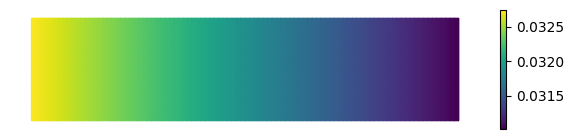

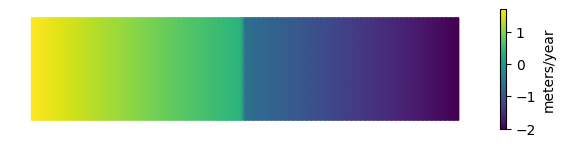

  4%|▍         | 22/500 [00:07<02:32,  3.13it/s]


KeyboardInterrupt: 

In [9]:
ice_stream_sol = acc_rates(10)